In [2]:
from tqdm import tqdm
from models.func import count_lemmas
from config import DocumentStatusType
from common.db_service import get_mongo_db_document_service

db = get_mongo_db_document_service()

words_counter = count_lemmas(tqdm(db_list))

71949it [02:36, 459.27it/s] 


In [253]:
next(db_list)

StopIteration: 

In [286]:
print(len(words_counter))
print(words_counter.most_common(7500)[-10:])

901070
[('особенности', 798), ('ипм', 798), ('кэш', 798), ('угату', 797), ('таковым', 797), ('магистратура', 797), ('контент', 797), ('дешевый', 796), ('грама', 796), ('эфир', 796)]


In [290]:
from common.db_service import MongoDbCrudService
from collections import Counter
from common.models import ArticleDocument
from common.db_repository import DocumentType
import json
import pickle
from dataclasses import dataclass, field
from typing import Iterable
from zipfile import ZIP_DEFLATED, ZipFile

from pymongo.cursor import Cursor
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm


def get_lemmas_count(data: Iterable[DocumentType], field_name="lemmas") -> Counter:
    """Счетчик количества слов."""
    counter = Counter()
    for document in data:
        for key, val in document[field_name].items():
            words = val.split()
            for word in words:
                counter[word] += 1
    return counter


def get_db_list(db: MongoDbCrudService) -> Cursor[DocumentType]:
    """Возвращает итератор по полностью обработанным документам."""
    db_list = db.list(
        {
            "parse_status": DocumentStatusType.COMPLETED,
            "processing_status": DocumentStatusType.COMPLETED,
            "lemmatization_status": DocumentStatusType.COMPLETED,
        }
    )
    return db_list

@dataclass
class ArticlesLemmasIterator:
    """Класс для итерации по аттрибутам коллекции документов."""

    db_list: Cursor[DocumentType]
    lemmas_fields: list
    _stack: list = field(default_factory=list)
    objects_ids: dict = field(default_factory=dict)
    counter = 0

    def __iter__(self):
        return self

    def __next__(self):
        article = ArticleDocument(**self.db_list.next())
        self.objects_ids[self.counter] = article._id
        self.counter += 1
        lemmas = " ".join(
            [val for key, val in article.lemmas.items() if key in self.lemmas_fields]
        )
        return lemmas


def make_tfidf_matrix(data: Iterable[str], vocabulary):
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=(1, 1),
        encoding="utf-8",
        vocabulary=vocabulary,
    )
    matrix = tfidf_vectorizer.fit_transform(data)
    return matrix



# db = get_mongo_db_document_service()
# Считаем количество повторений каждой леммы в текстах
lemmas_counter = get_lemmas_count(tqdm(get_db_list(db)))
#


71949it [08:53, 134.93it/s]


In [292]:
lemmas_vocabulary = [word for word, _ in lemmas_counter.most_common(7500)]

lemmas_iterator = ArticlesLemmasIterator(
    get_db_list(db), ["text", "abstract", "keywords", "title"]
)

tfidf_matrix = make_tfidf_matrix(
    tqdm(lemmas_iterator), vocabulary=lemmas_vocabulary
)


0it [00:00, ?it/s]
1it [00:01,  1.37s/it]
102it [00:05, 22.02it/s]
244it [00:05, 63.97it/s]
384it [00:05, 118.86it/s]
488it [00:07, 79.29it/s] 
613it [00:07, 121.01it/s]
730it [00:07, 171.81it/s]
858it [00:07, 243.44it/s]
963it [00:11, 80.48it/s] 
1123it [00:11, 126.46it/s]
1253it [00:13, 92.62it/s] 
1388it [00:13, 130.80it/s]
1540it [00:13, 188.51it/s]
1649it [00:15, 113.42it/s]
1796it [00:15, 163.05it/s]
1930it [00:16, 221.43it/s]
2039it [00:19, 91.55it/s] 
2156it [00:19, 124.03it/s]
2280it [00:19, 170.01it/s]
2380it [00:21, 108.51it/s]
2520it [00:21, 158.05it/s]
2625it [00:21, 204.32it/s]
2734it [00:23, 118.72it/s]
2842it [00:23, 159.32it/s]
2931it [00:23, 200.74it/s]
3053it [00:26, 82.10it/s] 
3205it [00:26, 126.39it/s]
3362it [00:27, 187.19it/s]
3474it [00:29, 110.39it/s]
3604it [00:29, 153.06it/s]
3733it [00:29, 208.55it/s]
3880it [00:29, 290.68it/s]
3997it [00:31, 144.07it/s]
4137it [00:31, 201.50it/s]
4261it [00:33, 126.82it/s]
4370it [00:33, 165.55it/s]
4487it [00:33, 220.07i

In [302]:
from bson import json_util

with ZipFile(
    "tfidf_matrix.zip", "w", compression=ZIP_DEFLATED, compresslevel=9,
) as zip_file:
    with zip_file.open("tfidf_matrix.pkl", "w") as file:
        pickle.dump(tfidf_matrix, file, protocol=pickle.HIGHEST_PROTOCOL)
    zip_file.writestr(
        "tfidf_matrix_objects.json", 
        data=json_util.dumps(lemmas_iterator.objects_ids, ensure_ascii=False, indent=3),
    )

In [300]:
json_util.dumps(lemmas_iterator.objects_ids, ensure_ascii=False, indent=3)

'{\n   "0": {\n      "$oid": "64161e4f702fbeb723e777b6"\n   },\n   "1": {\n      "$oid": "64161e4f702fbeb723e777b7"\n   },\n   "2": {\n      "$oid": "64161e4f702fbeb723e777b8"\n   },\n   "3": {\n      "$oid": "64161e4f702fbeb723e777b9"\n   },\n   "4": {\n      "$oid": "64161e4f702fbeb723e777ba"\n   },\n   "5": {\n      "$oid": "64161e4f702fbeb723e777bb"\n   },\n   "6": {\n      "$oid": "64161e4f702fbeb723e777bc"\n   },\n   "7": {\n      "$oid": "64161e4f702fbeb723e777bd"\n   },\n   "8": {\n      "$oid": "64161e4f702fbeb723e777be"\n   },\n   "9": {\n      "$oid": "64161e4f702fbeb723e777bf"\n   },\n   "10": {\n      "$oid": "64161e4f702fbeb723e777c0"\n   },\n   "11": {\n      "$oid": "64161e4f702fbeb723e777c1"\n   },\n   "12": {\n      "$oid": "64161e4f702fbeb723e777c2"\n   },\n   "13": {\n      "$oid": "64161e4f702fbeb723e777c3"\n   },\n   "14": {\n      "$oid": "64161e4f702fbeb723e777c4"\n   },\n   "15": {\n      "$oid": "64161e4f702fbeb723e777c5"\n   },\n   "16": {\n      "$oid": "641

In [293]:
lemmas_iterator.objects_ids

{0: ObjectId('64161e4f702fbeb723e777b6'),
 1: ObjectId('64161e4f702fbeb723e777b7'),
 2: ObjectId('64161e4f702fbeb723e777b8'),
 3: ObjectId('64161e4f702fbeb723e777b9'),
 4: ObjectId('64161e4f702fbeb723e777ba'),
 5: ObjectId('64161e4f702fbeb723e777bb'),
 6: ObjectId('64161e4f702fbeb723e777bc'),
 7: ObjectId('64161e4f702fbeb723e777bd'),
 8: ObjectId('64161e4f702fbeb723e777be'),
 9: ObjectId('64161e4f702fbeb723e777bf'),
 10: ObjectId('64161e4f702fbeb723e777c0'),
 11: ObjectId('64161e4f702fbeb723e777c1'),
 12: ObjectId('64161e4f702fbeb723e777c2'),
 13: ObjectId('64161e4f702fbeb723e777c3'),
 14: ObjectId('64161e4f702fbeb723e777c4'),
 15: ObjectId('64161e4f702fbeb723e777c5'),
 16: ObjectId('64161e4f702fbeb723e777c6'),
 17: ObjectId('64161e4f702fbeb723e777c7'),
 18: ObjectId('64161e4f702fbeb723e777c8'),
 19: ObjectId('64161e4f702fbeb723e777c9'),
 20: ObjectId('64161e50702fbeb723e777ca'),
 21: ObjectId('64161e50702fbeb723e777cb'),
 22: ObjectId('64161e50702fbeb723e777cc'),
 23: ObjectId('64161e

In [ ]:
tfidf_matrix.

In [273]:
from zipfile import ZIP_DEFLATED, ZipFile
import pickle

with ZipFile('tfidf_vectorizer.zip', "w", compression=ZIP_DEFLATED, compresslevel=9) as myzip:
    with myzip.open('tfidf_vectorizer.pkl', 'w') as file:
        pickle.dump(X, file, protocol=pickle.HIGHEST_PROTOCOL)

In [281]:
with ZipFile('tfidf_vectorizer.zip') as myzip:
    with myzip.open('tfidf_vectorizer.pkl') as file:
        tfidf_model = pickle.load(file)


In [285]:
import numpy as np


def cosine_sim(a, b):
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim

def search_similar(text: str, size: int, tfidf_matrix):
    search_lemma = ' '.join(tokenize(text))
    vector_new = tfidf_vectorizer.transform([search_lemma]).toarray()
    cosines = enumerate(
        [cosine_sim(vector.reshape(-1,), vector_new.reshape(-1,)) for vector in X.toarray()]
    )
    return sorted(cosines, key=lambda x: x[1], reverse=True)[:size]

scipy.sparse._csr.csr_matrix

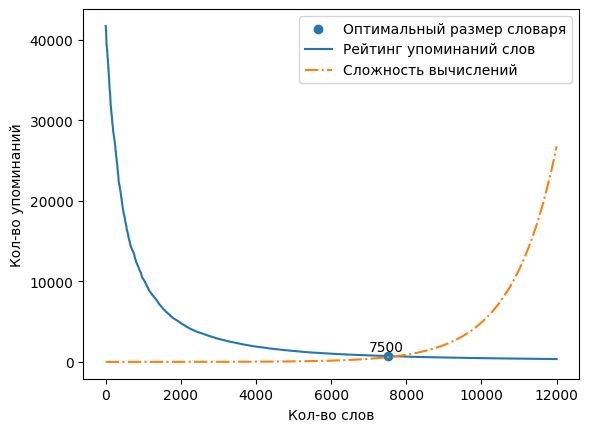

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame.from_records(words_counter.most_common(12400)[400:], columns=["word", "count"])

plt.style.use('default')

x = df.index
y = df["count"].astype(int)
plt.scatter(7500, df["count"].loc[7500], label="point")
plt.annotate("7500", (7000, df["count"].loc[5000]))
# plt.axis((0, 6, 0, 20))
plt.ylabel("Кол-во упоминаний")
plt.xlabel("Кол-во слов")
y2 = [1.00085 ** x if 1.00085 ** x < 40000 else 40000 for x in range(12000)]
plt.plot(x, y, label ='word counts')
plt.plot(x, y2, '-.', label ='complexity')
plt.legend(["Оптимальный размер словаря", "Рейтинг упоминаний слов", "Сложность вычислений"])

# axs[0].hist(dist1, bins=n_bins)